## Лабораторная 3: метод ближайших соседей (kNN)

В рамках этого занятия мы будем создавать модель для предсказания выживших пассажиров на "Титанике" (классическое учебное Kaggle [соревнование](https://www.kaggle.com/c/titanic)).

![Титаник](http://staff.mmcs.sfedu.ru/~sguda/MachineLearning/titanic.png)

## 1

Загрузите данные о погибших в катастрофе с "Титаником". Целевым признаком здесь является факт спасения пассажира. Посмотрите на данные.

In [1]:
import pandas as pd

In [9]:
# место для кода
data = pd.read_csv("data.csv",delimiter=',')

In [10]:
# место для кода
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [ ]:
# место для кода

Для простоты исключите пассажиров с неизвестным возрастом и заново перенумеруйте строки

*Функции, которые могут пригодиться при решении: `.dropna(subset='Age'), .reset_index(drop=True)`*

In [13]:
# место для кода
data.dropna(subset = ['Age'],inplace=True)
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000
mean,448.582633,0.406162,2.236695,29.699118,0.512605,0.431373,34.694514
std,259.119524,0.491460,0.838250,14.526497,0.929783,0.853289,52.918930
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.250000,0.000000,1.000000,20.125000,0.000000,0.000000,8.050000
50%,445.000000,0.000000,2.000000,28.000000,0.000000,0.000000,15.741700
75%,677.750000,1.000000,3.000000,38.000000,1.000000,1.000000,33.375000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


## 2

Постройте график рассеяния с возрастом в качестве оси абсцисс и ценой билета в качестве оси ординат. Отметьте красным — погибших, зеленым — спасшихся пассажиров. Постройте отдельно 2 графика: для женщин и для мужчин. 

Выполняется ли для данного множества гипотеза компактности?

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt

In [18]:
# место для кода
data_males = data[data['Sex']=='male']
data_females = data[data['Sex']=='female']

<Figure size 1728x432 with 0 Axes>

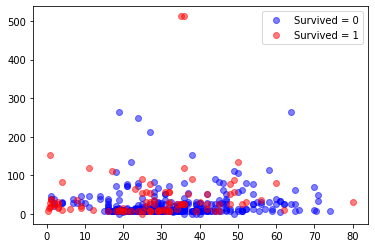

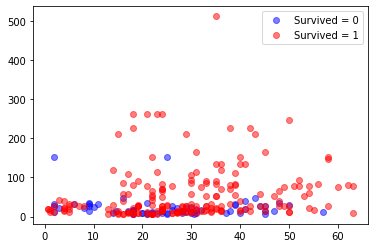

In [25]:
#Построим график 1 способом
fig = plt.figure(figsize=(24, 6))
groups = data_males.groupby('Survived')
colors = ['blue','red']
fig1,ax = plt.subplots()
for tmp,color in zip(groups, colors):
    name, group = tmp
    ax.plot(group["Age"], group["Fare"], marker="o", linestyle="", label='Survived = ' + str(name),color = color,alpha=0.5)
plt.legend()
groups = data_females.groupby('Survived')
colors = ['blue','red']
fig1,ax = plt.subplots()
for tmp,color in zip(groups, colors):
    name, group = tmp
    ax.plot(group["Age"], group["Fare"], marker="o", linestyle="", label='Survived = ' + str(name),color = color,alpha=0.5)
plt.legend()

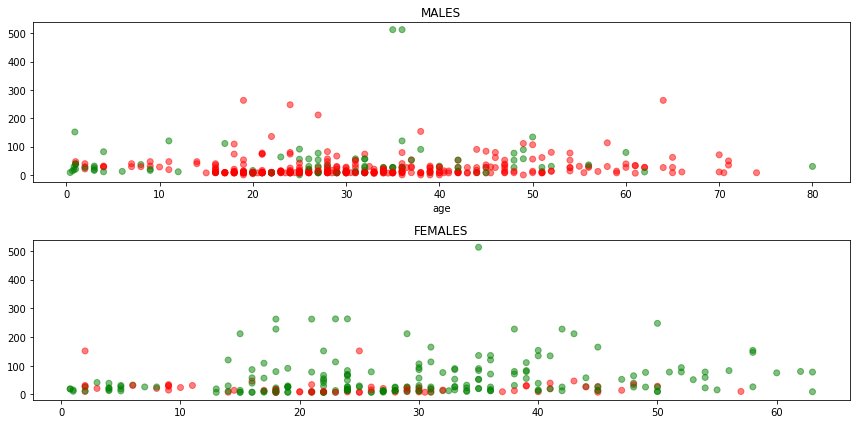

In [49]:
# А теперь 2 способом
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('customcmap',['red','green'])
#Males
fig1,(ax1,ax2) = plt.subplots(2,1,figsize=(12,6))
ax1.scatter(data_males["Age"], data_males["Fare"],c=data_males["Survived"],cmap = cmap,alpha = 0.5)
ax1.set_title("MALES")
ax1.set_xlabel('age')
ax2.scatter(data_females["Age"], data_females["Fare"],c=data_females["Survived"],cmap = cmap,alpha = 0.5)
ax2.set_title("FEMALES")
plt.tight_layout()

## 3 

Для построения модели нам понадобится метрика близости пассажиров. Запрограммируем функцию вычисления расстояния между пассажирами:

In [ ]:
def distance(a,b):
    d = 0
    d += abs(a['Pclass'] - b['Pclass'])
    d += a['Sex'] != b['Sex']
    d += abs(a['Age'] - b['Age'])
    d += abs(a['SibSp'] - b['SibSp'])
    d += abs(a['Parch'] - b['Parch'])
    d += abs(a['Fare'] - b['Fare'])
    d += a['Embarked'] != b['Embarked']
    return d

Метод `KNeighborsClassifier` из библиотеки `sklearn` излишне требователен к типам данных. Запрограммируем метод `k` ближайших соседей вручную:

In [ ]:
import numpy as np
import tqdm

In [ ]:
def myKNeighborsClassifier(learnData, K, passengerIndexForPrediction):
    dists = np.zeros((learnData.shape[0] - 1, 2))
    i = 0
    for idx, row in learnData.iterrows():
        if idx != passengerIndexForPrediction:  #LOO метод контроля ошибки
            dists[i][0] = distance(learnData.loc[passengerIndexForPrediction,], row)
            dists[i][1] = row['Survived']
            i += 1
    dists = sorted(dists, key = lambda pair: pair[0])
    prediction = 0
    for i in range(K): 
        prediction += dists[i][1]
    prediction /= K
    return round(prediction)

Запустите предсказание для всех пассажиров судна и, используя LOO-контроль ошибки оцените качество классификации:

In [ ]:
accuracy = 0
for idx, row in tqdm.tqdm(data.iterrows(), total=len(data)):
    accuracy += row['Survived'] == myKNeighborsClassifier(data, 5, idx)
print(accuracy/data.shape[0])

Подберите слагаемые в метрике, их веса и количество соседей так, чтобы качество классификации было максимальным. 

Если функция на `python` работает долго, воспользуйтесь ее аналогом на 
С++:  `KNeighborsClassifier.cpp.` 

Компиляция на Linux выполняется командой 

    g++ -O2 KNeighborsClassifier.cpp -o  KNeighborsClassifier


Запуск: 

    ./KNeighborsClassifier
    
Построившему метрику с наилучшим качеством: +5 бонусных баллов.

## 4

Создайте копию функции `myKNeighborsClassifier` и измените ее так, чтобы она считала выступ объекта. Назовите ее `calcMargin`. 

Вычислите выступы для всех объектов и выведите информацию о пяти объектах с минимальным выступом (шумовых выбросах) и пяти объектах с максимальным выступом (эталонах). Объясните в комментариях полученные данные.

In [ ]:
# место для кода

In [ ]:
# место для кода

In [ ]:
# место для кода

Это легче всего сделать с помощью функции `np.argsort`, возвращающей индексы элементов в отсортированном ряду:

In [ ]:
idx = np.argsort(margins)

In [ ]:
print('Белые вороны (аномалии)')
data.loc[idx[:5],]

In [ ]:
print('Эталоны (характерные объекты)')
data.loc[idx[-5:],]